# Tuning 

- Author: Israel Oliveira [\[e-mail\]](mailto:'Israel%20Oliveira%20'<prof.israel@gmail.com>)

In [1]:
%load_ext watermark

In [2]:
import pandas as pd
import numpy as np
from random_forest_mc.model import RandomForestMC
from random_forest_mc.utils import LoadDicts, dump_file_json, load_file_json
from tqdm.notebook import tqdm
from datetime import datetime
from collections import Counter, defaultdict
from glob import glob
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib 

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rcParams
from cycler import cycler

rcParams['figure.figsize'] = 6, 2 # 18, 5
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['axes.grid'] = True
rcParams['axes.prop_cycle'] = cycler(color=['#365977'])
rcParams['lines.linewidth'] = 2.5

In [4]:
import warnings
warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)

In [5]:
import functools
import operator
def flat(a):
    return functools.reduce(operator.iconcat, a, [])

In [6]:
# Run this cell before close.
%watermark -d --iversion -b -r -g -m -v
!cat /proc/cpuinfo |grep 'model name'|head -n 1 |sed -e 's/model\ name/CPU/'
!free -h |cut -d'i' -f1  |grep -v total

Python implementation: CPython
Python version       : 3.11.10
IPython version      : 8.27.0

Compiler    : GCC 10.2.1 20210110
OS          : Linux
Release     : 6.8.0-44-generic
Machine     : x86_64
Processor   : 
CPU cores   : 20
Architecture: 64bit

Git hash: afffba9ffbd19f4c4b696c18f695f73af62368d0

Git repo: https://github.com/ysraell/random-forest-mc-utils.git

Git branch: main

numpy     : 1.26.4
pandas    : 2.2.2
matplotlib: 3.9.2

CPU	: 12th Gen Intel(R) Core(TM) i7-12700
Mem:            15G
Swap:          3.7G


In [7]:
dataset_path = '/work/tmp/credit-card-fraud-prediction'

In [8]:
!ls $dataset_path

model_trans_tuning_256trees_20240917_1808.json
model_trans_tuning_32trees_20240917_1322.json
model_trans_tuning_32trees_20240917_1416.json
model_tuned_256trees_20240918_0134.json
model_tuned_not_trans_256trees_20240918_0559.json
sample_submission.csv
submission_exp1.csv
submission_exp2_trans.csv
submission_exp2_trans_probs.csv
submission_exp2_trans_probs2.csv
submission_exp2_trans_probs4.csv
submission_exp2_trans_t2.csv
submission_exp2_trans_t3.csv
submission_exp2_trans_t4.csv
submission_exp2_trans_t5.csv
submission_exp2_trans_t6.csv
submission_exp4_not_trans_probs1.csv
submission_sklearn_exp1.csv
submission_sklearn_exp1_proba.csv
submission_sklearn_exp1_proba2.csv
submission_sklearn_exp1_proba3.csv
submission_sklearn_exp2_proba1.csv
test.csv
test_trans.csv
train.csv
train_trans.csv
trees_trans_metrcis_sim_20240917_1950.json


In [9]:
df = pd.read_csv(f'{dataset_path}/train.csv')
#df = df.drop(columns='Time')
target_col = 'IsFraud'
df[target_col] = df[target_col].astype(str)
feat_cols = df.columns.to_list()
feat_cols.remove('id')
feat_cols.remove(target_col)
IsFraud_count, Not_IsFraud_count = df[target_col].value_counts()['1'], df[target_col].value_counts()['0']
IsFraud_count, Not_IsFraud_count

(269, 149731)

In [10]:
split_schema = {
    'test': {
        '1': 10,
        '0': 10000,
    },
    'train': {
        '1': 239,
        '0': 50000,
    },
    'val': {
        '1': 20,
        '0': 6900,
    }
}

In [11]:
df_tmp = df.copy()

dfs = {}
for ds_set in split_schema.keys():
    df_set = pd.concat([
        df_tmp.query(f'{target_col} == "{target_val}"').sample(n=split_schema[ds_set][target_val], random_state=42)
        for target_val in ['1', '0']
    ])
    df_tmp = df_tmp.drop(df_set.index).reset_index(drop=True)
    dfs[ds_set] = df_set.reset_index(drop=True)

df_tofit = pd.concat([dfs['train'], dfs['val']])

In [12]:
df_tmp.shape[0], df_tofit.shape[0], dfs['test'].shape[0], df_tmp.shape[0] + df_tofit.shape[0] + dfs['test'].shape[0]

(82831, 57159, 10010, 150000)

In [16]:
batch_train_pclass = split_schema['train']['1']
batch_val_pclass = split_schema['val']['1']
max_depth = None
n_trees = 256
max_discard_trees = 256
min_feature = 2
max_feature = 16

cpu_cores = 8
max_workers = 16

cls = RandomForestMC(
    n_trees=n_trees, 
    target_col=target_col, 
    max_discard_trees=max_discard_trees,
    batch_train_pclass=batch_train_pclass,
    batch_val_pclass=batch_val_pclass,
    min_feature=min_feature,
    max_feature=max_feature,
    max_depth=max_depth
)
cls

RandomForestMC(len(Forest)=0,n_trees=256,model_version=1.2.0-dev,module_version=1.2.0-dev)

In [13]:
df_test = dfs['test']
y_test = df_test[target_col].astype(int).to_list()
ppy = lambda x: round(100*x, 6)

In [57]:
df_tofit.columns

Index(['id', 'Time', 'feat1', 'feat2', 'feat3', 'feat4', 'feat5', 'feat6',
       'feat7', 'feat8', 'feat9', 'feat10', 'feat11', 'feat12', 'feat13',
       'feat14', 'feat15', 'feat16', 'feat17', 'feat18', 'feat19', 'feat20',
       'feat21', 'feat22', 'feat23', 'feat24', 'feat25', 'feat26', 'feat27',
       'feat28', 'Transaction_Amount', 'IsFraud'],
      dtype='object')

# Create the model

In [18]:
cls.fitParallel(dataset=df_tofit, max_workers=max_workers)
ModelDict = cls.model2dict()
datetime_tag = datetime.now().strftime('%Y%m%d_%H%M')
path_dict = f'{dataset_path}/model_tuned_not_trans_{len(cls)}trees_{datetime_tag}.json'
dump_file_json(path_dict, ModelDict)
del ModelDict

Planting the forest:   0%|          | 0/256 [00:00<?, ?it/s]

In [ ]:
cls.setSoftVoting()
y_pred_soft = np.array(cls.testForest(df_test)).astype(int)
accuracy_soft = accuracy_score(y_test, y_pred_soft)
f1_score_soft = f1_score(y_test, y_pred_soft)

print(f"{len(cls)} Trees")
cm = confusion_matrix(y_test, y_pred_soft)
display(pd.DataFrame(cm, columns=['Pred False','Pred True'], index=['False','True']))
tn, fp, fn, tp = cm.ravel()
obj_score = fn / (fn+tp)
print(f"Acc: {ppy(accuracy_soft):.4f}% \n F1: {ppy(f1_score_soft):.4f}% \n FN: {ppy(obj_score):.4f}%")

fc_stars, fc_list = cls.featCount()
print(f"Feat count stats: {fc_stars}")
Counter(fc_list).most_common()

In [ ]:
cls.fitParallel(dataset=df_tofit, max_workers=max_workers)
ModelDict = cls.model2dict()
datetime_tag = datetime.now().strftime('%Y%m%d_%H%M')
path_dict = f'{dataset_path}/model_trans_tuning_{len(cls)}trees_{datetime_tag}.json'
dump_file_json(path_dict, ModelDict)
del ModelDict

In [ ]:
cls.setSoftVoting()
y_pred_soft = np.array(cls.testForest(df_test)).astype(int)
accuracy_soft = accuracy_score(y_test, y_pred_soft)
f1_score_soft = f1_score(y_test, y_pred_soft)

print(f"{len(cls)} Trees")
cm = confusion_matrix(y_test, y_pred_soft)
display(pd.DataFrame(cm, columns=['Pred False','Pred True'], index=['False','True']))
tn, fp, fn, tp = cm.ravel()
obj_score = fn / (fn+tp)
print(f"Acc: {ppy(accuracy_soft):.4f}% \n F1: {ppy(f1_score_soft):.4f}% \n FN: {ppy(obj_score):.4f}%")

fc_stars, fc_list = cls.featCount()
print(f"Feat count stats: {fc_stars}")
Counter(fc_list).most_common()

In [ ]:
cls.n_trees = 16

In [ ]:
cls.fitParallel(dataset=df_tofit, max_workers=max_workers)
ModelDict = cls.model2dict()
datetime_tag = datetime.now().strftime('%Y%m%d_%H%M')
path_dict = f'{dataset_path}/model_trans_tuning_{len(cls)}trees_{datetime_tag}.json'
dump_file_json(path_dict, ModelDict)
del ModelDict

In [ ]:
cls.setSoftVoting()
y_pred_soft = np.array(cls.testForest(df_test)).astype(int)
accuracy_soft = accuracy_score(y_test, y_pred_soft)
f1_score_soft = f1_score(y_test, y_pred_soft)

print(f"{len(cls)} Trees")
cm = confusion_matrix(y_test, y_pred_soft)
display(pd.DataFrame(cm, columns=['Pred False','Pred True'], index=['False','True']))
tn, fp, fn, tp = cm.ravel()
obj_score = fn / (fn+tp)
print(f"Acc: {ppy(accuracy_soft):.4f}% \n F1: {ppy(f1_score_soft):.4f}% \n FN: {ppy(obj_score):.4f}%")

fc_stars, fc_list = cls.featCount()
print(f"Feat count stats: {fc_stars}")
Counter(fc_list).most_common()

In [ ]:
cls.n_trees = 256
max_workers = 16

In [ ]:
cls.fitParallel(dataset=df_tofit, max_workers=max_workers)
ModelDict = cls.model2dict()
datetime_tag = datetime.now().strftime('%Y%m%d_%H%M')
path_dict = f'{dataset_path}/model_trans_tuning_{len(cls)}trees_{datetime_tag}.json'
dump_file_json(path_dict, ModelDict)
del ModelDict

In [ ]:
cls.setSoftVoting()
y_pred_soft = np.array(cls.testForest(df_test)).astype(int)
accuracy_soft = accuracy_score(y_test, y_pred_soft)
f1_score_soft = f1_score(y_test, y_pred_soft)

print(f"{len(cls)} Trees")
cm = confusion_matrix(y_test, y_pred_soft)
display(pd.DataFrame(cm, columns=['Pred False','Pred True'], index=['False','True']))
tn, fp, fn, tp = cm.ravel()
obj_score = fn / (fn+tp)
print(f"Acc: {ppy(accuracy_soft):.4f}% \n F1: {ppy(f1_score_soft):.4f}% \n FN: {ppy(obj_score):.4f}%")

fc_stars, fc_list = cls.featCount()
print(f"Feat count stats: {fc_stars}")
Counter(fc_list).most_common()

# Search for the best set of trees

In [15]:
cls = RandomForestMC(target_col=target_col)
cls.process_dataset(df_tofit)

In [17]:
!ls -l $dataset_path/model_*

-rw-r--r-- 1 root root 200869760 Sep 17 18:08 /work/tmp/credit-card-fraud-prediction/model_trans_tuning_256trees_20240917_1808.json
-rw-r--r-- 1 root root   8653992 Sep 17 13:22 /work/tmp/credit-card-fraud-prediction/model_trans_tuning_32trees_20240917_1322.json
-rw-r--r-- 1 root root  25235821 Sep 17 14:16 /work/tmp/credit-card-fraud-prediction/model_trans_tuning_32trees_20240917_1416.json
-rw-r--r-- 1 root root 200669551 Sep 18 01:34 /work/tmp/credit-card-fraud-prediction/model_tuned_256trees_20240918_0134.json
-rw-r--r-- 1 root root 201051079 Sep 18 05:59 /work/tmp/credit-card-fraud-prediction/model_tuned_not_trans_256trees_20240918_0559.json


In [53]:
model_json = f'{dataset_path}/model_tuned_not_trans_256trees_20240918_0559.json'
model_dict = load_file_json(model_json)
cls.dict2model(model_dict)
cls

RandomForestMC(len(Forest)=256,n_trees=256,model_version=1.2.0-dev,module_version=1.2.0-dev)

,Depths
count,117293.000000
mean,10.122625
std,0.835727
min,6.000000
25%,10.000000
50%,10.000000
75%,11.000000
max,13.000000


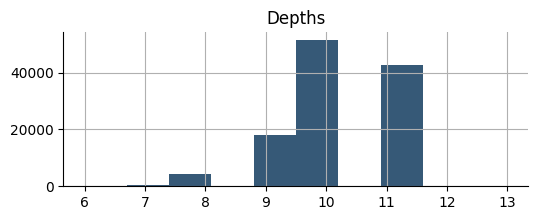

In [19]:
dps = cls.trees2depths
df_dethps = pd.DataFrame(flat(dps), columns=['Depths'])
df_dethps.hist()
df_dethps.describe()

In [ ]:
cls_inc = RandomForestMC(target_col=target_col)
cls_inc.process_dataset(df_tofit)
df_frauds = df_test.query(f'{target_col} == "1"').reset_index(drop=True)

tp_soft = []
tp_hard = []
final_N = cls.Forest_size
for i in tqdm(range(1,final_N)):
    cls_inc.reset_forest()
    cls_inc.mergeForest(cls, N=i, by="score")
    cls_inc.setSoftVoting(True)
    y_pred_soft = np.array(cls_inc.testForest(df_frauds)).astype(int)
    tp_soft.append(sum(y_pred_soft))
    cls_inc.setSoftVoting(False)
    y_pred_hard = np.array(cls_inc.testForest(df_frauds)).astype(int)
    tp_hard.append(sum(y_pred_hard))

In [ ]:
df_soft = pd.DataFrame(tp_soft)
df_soft.plot()
df_soft.describe()

In [ ]:
df_hard = pd.DataFrame(tp_hard)
df_hard.plot()
df_hard.describe()

In [ ]:
cls_inc = RandomForestMC(target_col=target_col)
cls_inc.process_dataset(df_tofit)
df_frauds = df_test.query(f'{target_col} == "1"').reset_index(drop=True)

tp_soft = []
tp_hard = []
final_N = cls.Forest_size
for i in tqdm(range(1,final_N)):
    cls_inc.reset_forest()
    cls_inc.mergeForest(cls, N=i, by="random")
    cls_inc.setSoftVoting(True)
    y_pred_soft = np.array(cls_inc.testForest(df_frauds)).astype(int)
    tp_soft.append(sum(y_pred_soft))
    cls_inc.setSoftVoting(False)
    y_pred_hard = np.array(cls_inc.testForest(df_frauds)).astype(int)
    tp_hard.append(sum(y_pred_hard))

In [ ]:
df_soft = pd.DataFrame(tp_soft)
df_soft.plot()
df_soft.describe()

In [ ]:
df_hard = pd.DataFrame(tp_hard)
df_hard.plot()
df_hard.describe()

In [ ]:
cls_inc = RandomForestMC(target_col=target_col)
cls_inc.process_dataset(df_tofit)
df_frauds = df_test.query(f'{target_col} == "1"').reset_index(drop=True)

N_sim = 100

data = []
final_N = cls.Forest_size
for i in tqdm(range(1,final_N)):
    tp = []
    for _ in range(N_sim):
        cls_inc.reset_forest()
        cls_inc.mergeForest(cls, N=i, by="random")
        cls_inc.setSoftVoting(True)
        y_pred_soft = np.array(cls_inc.testForest(df_frauds)).astype(int)
        tp.append(sum(y_pred_soft))
    data.append(tp)

In [ ]:
df = pd.DataFrame(data).T

plt.figure()
df.boxplot()

In [ ]:
df.describe().T.sort_values(by='mean', ascending=False).head(20)

In [ ]:
cls_inc = RandomForestMC(target_col=target_col)
cls_inc.process_dataset(df_tofit)
df_frauds = df_test.query(f'{target_col} == "1"').reset_index(drop=True)

N_sim = 1000

data = []
final_N = 10
for i in tqdm(range(1,final_N)):
    tp = []
    for _ in range(N_sim):
        cls_inc.reset_forest()
        cls_inc.mergeForest(cls, N=i, by="random")
        cls_inc.setSoftVoting(True)
        y_pred_soft = np.array(cls_inc.testForest(df_frauds)).astype(int)
        tp.append(sum(y_pred_soft))
    data.append(tp)

In [ ]:
df = pd.DataFrame(data).T

plt.figure()
df.boxplot()

In [ ]:
df.describe().T.sort_values(by='mean', ascending=False).head(20)

# Tunning 3 with search 2-4-6-trees

In [20]:
cls.drop_duplicated_trees()

0

In [21]:
cls

RandomForestMC(len(Forest)=256,n_trees=256,model_version=1.2.0-dev,module_version=1.2.0-dev)

In [22]:
cls_inc = RandomForestMC(target_col=target_col)
cls_inc.process_dataset(df_tofit)
cls_inc.setSoftVoting(True)
df_frauds = df_test.query(f'{target_col} == "1"').reset_index(drop=True)
df_notfrauds = df_test.query(f'{target_col} == "0"').sample(n=1000).reset_index(drop=True)
df_mini_test = pd.concat([df_frauds, df_notfrauds], ignore_index=True)
y_test = df_mini_test[target_col].astype(int).to_list()

N_sim = 10000

data = defaultdict(list)
n_trees = [8]
for _ in tqdm(range(N_sim)):
    repated_forest = set()
    for i in n_trees:
        cls_inc.reset_forest()
        cls_inc.mergeForest(cls, N=i, by="random")
        hd5_forest = "".join(sorted([Tree.md5hexdigest for Tree in cls_inc]))
        if hd5_forest in repated_forest:
            continue
        repated_forest.add(hd5_forest)
        y_pred_soft = np.array(cls_inc.testForest(df_mini_test)).astype(int)
        acc = accuracy_score(y_test, y_pred_soft)
        f1 = f1_score(y_test, y_pred_soft)
        miss_rate = sum([not p for t, p in zip(y_test, y_pred_soft) if t]) / sum(y_test)
        for Tree in cls_inc:
            data[Tree.md5hexdigest].append((i, len(Tree.used_features), max(Tree.depths), acc, f1, miss_rate))

  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
datetime_tag = datetime.now().strftime('%Y%m%d_%H%M')
dump_file_json(f"{dataset_path}/trees_trans_metrcis_sim_{datetime_tag}.json", data)

In [ ]:
len(data)

### Analysing the results

In [ ]:
!ls $dataset_path/trees_metrcis_sim_*.json

In [ ]:
data =  load_file_json('/work/tmp/credit-card-fraud-prediction/trees_metrcis_sim2_*.json')

In [25]:
md5_trees = list(data.keys())

In [26]:
columns = ['Forest Size','Feature Count','Max Depths','Acc','F1','Miss Rate']
list_trees = []
for md5_tree, stats_tree in data.items():
    df_stats = pd.DataFrame(data[md5_tree], columns=columns).max().to_frame().T
    df_stats['Tree'] = md5_tree
    list_trees.append(df_stats)
    df_stats = pd.DataFrame(data[md5_tree], columns=columns).mean().to_frame().T
    df_stats['Tree'] = md5_tree
    list_trees.append(df_stats)

df_trees = pd.concat(list_trees, ignore_index=True)
df_trees

,Forest Size,Feature Count,Max Depths,Acc,F1,Miss Rate,Tree
0,8.0,10.0,11.0,0.896040,0.105263,0.900000,fc379ad5e0e5d42a6dda55ecf4ce56a2
1,8.0,10.0,11.0,0.862820,0.066244,0.509804,fc379ad5e0e5d42a6dda55ecf4ce56a2
2,8.0,11.0,11.0,0.890099,0.125984,0.800000,dd983fe76902628c9b02fcf4a311c192
3,8.0,11.0,11.0,0.856270,0.067481,0.477950,dd983fe76902628c9b02fcf4a311c192
4,8.0,5.0,12.0,0.892079,0.113821,0.800000,ebde71475a010d072986ef0fc458993c
...,...,...,...,...,...,...,...
507,8.0,5.0,11.0,0.858963,0.067953,0.481250,2bbc674be7a69a2f4cadca58c86ae654
508,8.0,6.0,11.0,0.892079,0.125000,0.700000,bc079c0d4237eec92e35e55ad5d307ce
509,8.0,6.0,11.0,0.859008,0.077433,0.404601,bc079c0d4237eec92e35e55ad5d307ce
510,8.0,10.0,11.0,0.886139,0.122137,0.800000,3fc746f9c16a7409d289f7b7c050881b


In [27]:
df_trees.sort_values(by='F1', ascending=False).head(10)

,Forest Size,Feature Count,Max Depths,Acc,F1,Miss Rate,Tree
226,8.0,11.0,12.0,0.894059,0.140625,0.9,7a634382da5ca88bc265f4b890b80f9e
378,8.0,10.0,11.0,0.892079,0.140625,0.8,8dade4808352d09d959b6933d4f3674a
388,8.0,10.0,11.0,0.891089,0.140625,0.9,5fdf011ebf84620a0b238bf20bce4d93
132,8.0,10.0,12.0,0.891089,0.140625,0.9,2049c6539035763062cd5b6476c6e8e5
342,8.0,10.0,11.0,0.891089,0.140625,0.8,feea0805c44d083f1ba727dbc6a68a71
72,8.0,10.0,11.0,0.893069,0.140625,0.8,a54dbe66761c55097db954add242008f
406,8.0,3.0,12.0,0.896040,0.140625,0.7,8739353b6c4c49a91c65f9493446dc3e
398,8.0,6.0,12.0,0.892079,0.140625,0.8,9c94fcaeae301efba395daa39aa89e96
96,8.0,10.0,11.0,0.889109,0.133333,0.8,f9d5dab45b99159578350288ffa86a4b
428,8.0,6.0,11.0,0.893069,0.133333,0.8,5ef75a63052c46bf15066a2d2619d5b1


In [28]:
df_trees.sort_values(by='Miss Rate').head(10)

,Forest Size,Feature Count,Max Depths,Acc,F1,Miss Rate,Tree
407,8.0,3.0,12.0,0.858575,0.081615,0.368222,8739353b6c4c49a91c65f9493446dc3e
375,8.0,10.0,11.0,0.849550,0.076881,0.369034,e67112b3264bf44b9d13a05183f11c31
459,8.0,11.0,12.0,0.863147,0.082621,0.380537,9b556ca72c25ad1a1e26ba1374c2e97e
27,8.0,10.0,11.0,0.851907,0.076329,0.384429,58a56d1ca90aab09b91c4ede7e38b447
55,8.0,6.0,11.0,0.856850,0.078531,0.385619,9083e2af23a756119bfffdbdfb443d58
43,8.0,4.0,11.0,0.854903,0.077516,0.386469,e881d202eafdadd087fe9fefd8e542a3
51,8.0,4.0,11.0,0.856227,0.078081,0.386994,14127220c29473819492e3b5591734ed
73,8.0,10.0,11.0,0.857278,0.078505,0.388199,a54dbe66761c55097db954add242008f
463,8.0,3.0,11.0,0.857174,0.078241,0.390960,0eb2b70988ac89b80b7549d46606160c
95,8.0,4.0,11.0,0.857319,0.078042,0.392063,bcf91b25345b36dc54c2380be99d72c1


<Axes: >

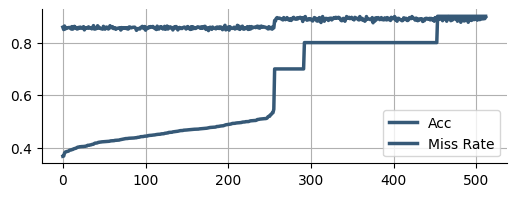

In [29]:
df_trees.sort_values(by='Miss Rate')[['Acc', 'Miss Rate']].reset_index(drop=True).plot(grid=True)

<Axes: >

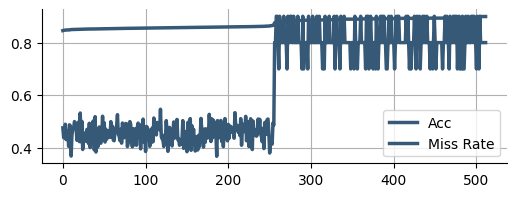

In [30]:
df_trees.sort_values(by='Acc')[['Acc', 'Miss Rate']].reset_index(drop=True).plot(grid=True)

<Axes: >

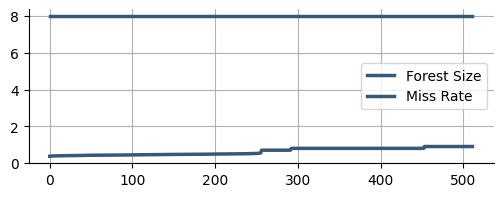

In [31]:
df_trees.sort_values(by='Miss Rate')[['Forest Size', 'Miss Rate']].reset_index(drop=True).plot(grid=True)

<Axes: >

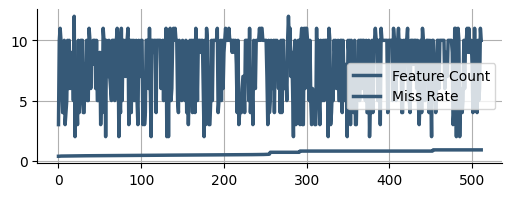

In [32]:
df_trees.sort_values(by='Miss Rate')[['Feature Count', 'Miss Rate']].reset_index(drop=True).plot(grid=True)

In [ ]:
!touch /work/yes.do

# Tuning 3

In [ ]:
batch_train_pclass = split_schema['train']['1']
batch_val_pclass = split_schema['val']['1']
max_depth = 11
n_trees = 256
max_discard_trees = 256
min_feature = 10
max_feature = 10

cpu_cores = 8
max_workers = 2*cpu_cores

cls = RandomForestMC(
    n_trees=n_trees, 
    target_col=target_col, 
    max_discard_trees=max_discard_trees,
    batch_train_pclass=batch_train_pclass,
    batch_val_pclass=batch_val_pclass,
    min_feature=min_feature,
    max_feature=max_feature,
    max_depth=max_depth
)
cls

In [ ]:
df_test = dfs['test']
y_test = df_test[target_col].astype(int).to_list()
ppy = lambda x: round(100*x, 6)

In [ ]:
cls.fitParallel(dataset=df_tofit, max_workers=max_workers)
ModelDict = cls.model2dict()
datetime_tag = datetime.now().strftime('%Y%m%d_%H%M')
path_dict = f'{dataset_path}/model_trans_tuning_{len(cls)}trees_{datetime_tag}.json'
dump_file_json(path_dict, ModelDict)
del ModelDict

In [ ]:
cls.setSoftVoting()
y_pred_soft = np.array(cls.testForest(df_test)).astype(int)
accuracy_soft = accuracy_score(y_test, y_pred_soft)
f1_score_soft = f1_score(y_test, y_pred_soft)

print(f"{len(cls)} Trees")
cm = confusion_matrix(y_test, y_pred_soft)
display(pd.DataFrame(cm, columns=['Pred False','Pred True'], index=['False','True']))
tn, fp, fn, tp = cm.ravel()
obj_score = fn / (fn+tp)
print(f"Acc: {ppy(accuracy_soft):.4f}% \n F1: {ppy(f1_score_soft):.4f}% \n FN: {ppy(obj_score):.4f}%")

fc_stars, fc_list = cls.featCount()
print(f"Feat count stats: {fc_stars}")
Counter(fc_list).most_common()

In [ ]:
cls.drop_duplicated_trees()

In [ ]:
cls

In [ ]:
cls_inc = RandomForestMC(target_col=target_col)
cls_inc.process_dataset(df_tofit)
cls_inc.setSoftVoting(True)
df_frauds = df_test.query(f'{target_col} == "1"').reset_index(drop=True)
df_notfrauds = df_test.query(f'{target_col} == "0"').sample(n=1000).reset_index(drop=True)
df_mini_test = pd.concat([df_frauds, df_notfrauds], ignore_index=True)
y_test = df_mini_test[target_col].astype(int).to_list()

N_sim = 10000

data = defaultdict(list)
n_trees = [4, 5, 6]
for _ in tqdm(range(N_sim)):
    repated_forest = set()
    for i in n_trees:
        cls_inc.reset_forest()
        cls_inc.mergeForest(cls, N=i, by="random")
        hd5_forest = "".join(sorted([Tree.md5hexdigest for Tree in cls_inc]))
        if hd5_forest in repated_forest:
            continue
        repated_forest.add(hd5_forest)
        y_pred_soft = np.array(cls_inc.testForest(df_mini_test)).astype(int)
        acc = accuracy_score(y_test, y_pred_soft)
        f1 = f1_score(y_test, y_pred_soft)
        miss_rate = sum([not p for t, p in zip(y_test, y_pred_soft) if t]) / sum(y_test)
        for Tree in cls_inc:
            data[Tree.md5hexdigest].append((i, len(Tree.used_features), max(Tree.depths), acc, f1, miss_rate))

In [ ]:
datetime_tag = datetime.now().strftime('%Y%m%d_%H%M')
dump_file_json(f"{dataset_path}/trees_trans_metrcis_sim2_{datetime_tag}.json", data)

In [ ]:
len(data)

### Analysing the results

In [ ]:
!ls $dataset_path/trees_metrcis_sim2_*.json

In [ ]:
data =  load_file_json('/work/tmp/credit-card-fraud-prediction/trees_metrcis_sim2_20240915_1804.json')

In [ ]:
md5_trees = list(data.keys())

In [ ]:
columns = ['Forest Size','Feature Count','Max Depths','Acc','F1','Miss Rate']
list_trees = []
for md5_tree, stats_tree in data.items():
    df_stats = pd.DataFrame(data[md5_tree], columns=columns).max().to_frame().T
    df_stats['Tree'] = md5_tree
    list_trees.append(df_stats)
    df_stats = pd.DataFrame(data[md5_tree], columns=columns).mean().to_frame().T
    df_stats['Tree'] = md5_tree
    list_trees.append(df_stats)

df_trees = pd.concat(list_trees, ignore_index=True)
df_trees

In [33]:
df_trees.sort_values(by='F1', ascending=False).head(10)

,Forest Size,Feature Count,Max Depths,Acc,F1,Miss Rate,Tree
226,8.0,11.0,12.0,0.894059,0.140625,0.9,7a634382da5ca88bc265f4b890b80f9e
378,8.0,10.0,11.0,0.892079,0.140625,0.8,8dade4808352d09d959b6933d4f3674a
388,8.0,10.0,11.0,0.891089,0.140625,0.9,5fdf011ebf84620a0b238bf20bce4d93
132,8.0,10.0,12.0,0.891089,0.140625,0.9,2049c6539035763062cd5b6476c6e8e5
342,8.0,10.0,11.0,0.891089,0.140625,0.8,feea0805c44d083f1ba727dbc6a68a71
72,8.0,10.0,11.0,0.893069,0.140625,0.8,a54dbe66761c55097db954add242008f
406,8.0,3.0,12.0,0.896040,0.140625,0.7,8739353b6c4c49a91c65f9493446dc3e
398,8.0,6.0,12.0,0.892079,0.140625,0.8,9c94fcaeae301efba395daa39aa89e96
96,8.0,10.0,11.0,0.889109,0.133333,0.8,f9d5dab45b99159578350288ffa86a4b
428,8.0,6.0,11.0,0.893069,0.133333,0.8,5ef75a63052c46bf15066a2d2619d5b1


In [34]:
df_trees.sort_values(by='Miss Rate').head(10)

,Forest Size,Feature Count,Max Depths,Acc,F1,Miss Rate,Tree
407,8.0,3.0,12.0,0.858575,0.081615,0.368222,8739353b6c4c49a91c65f9493446dc3e
375,8.0,10.0,11.0,0.849550,0.076881,0.369034,e67112b3264bf44b9d13a05183f11c31
459,8.0,11.0,12.0,0.863147,0.082621,0.380537,9b556ca72c25ad1a1e26ba1374c2e97e
27,8.0,10.0,11.0,0.851907,0.076329,0.384429,58a56d1ca90aab09b91c4ede7e38b447
55,8.0,6.0,11.0,0.856850,0.078531,0.385619,9083e2af23a756119bfffdbdfb443d58
43,8.0,4.0,11.0,0.854903,0.077516,0.386469,e881d202eafdadd087fe9fefd8e542a3
51,8.0,4.0,11.0,0.856227,0.078081,0.386994,14127220c29473819492e3b5591734ed
73,8.0,10.0,11.0,0.857278,0.078505,0.388199,a54dbe66761c55097db954add242008f
463,8.0,3.0,11.0,0.857174,0.078241,0.390960,0eb2b70988ac89b80b7549d46606160c
95,8.0,4.0,11.0,0.857319,0.078042,0.392063,bcf91b25345b36dc54c2380be99d72c1


In [35]:
df_trees['My Score'] = df_trees['Acc']-2*df_trees['Miss Rate']

In [36]:
df_trees.sort_values(by='My Score', ascending=False).head(10)

,Forest Size,Feature Count,Max Depths,Acc,F1,Miss Rate,Tree,My Score
407,8.0,3.0,12.0,0.858575,0.081615,0.368222,8739353b6c4c49a91c65f9493446dc3e,0.122131
375,8.0,10.0,11.0,0.849550,0.076881,0.369034,e67112b3264bf44b9d13a05183f11c31,0.111482
459,8.0,11.0,12.0,0.863147,0.082621,0.380537,9b556ca72c25ad1a1e26ba1374c2e97e,0.102073
55,8.0,6.0,11.0,0.856850,0.078531,0.385619,9083e2af23a756119bfffdbdfb443d58,0.085612
27,8.0,10.0,11.0,0.851907,0.076329,0.384429,58a56d1ca90aab09b91c4ede7e38b447,0.083048
51,8.0,4.0,11.0,0.856227,0.078081,0.386994,14127220c29473819492e3b5591734ed,0.082238
43,8.0,4.0,11.0,0.854903,0.077516,0.386469,e881d202eafdadd087fe9fefd8e542a3,0.081966
73,8.0,10.0,11.0,0.857278,0.078505,0.388199,a54dbe66761c55097db954add242008f,0.080881
463,8.0,3.0,11.0,0.857174,0.078241,0.390960,0eb2b70988ac89b80b7549d46606160c,0.075253
465,8.0,10.0,11.0,0.860848,0.079714,0.393769,8b12a867804b34a8cc5edf8a941f18f9,0.073311


In [37]:
golden_trees = df_trees.sort_values(by='My Score', ascending=False).head(128).Tree.to_list()

In [38]:
cls.data = [Tree for Tree in cls.data if Tree.md5hexdigest in golden_trees]

In [ ]:
cls

# Generate the submission file

In [46]:
df_test = pd.read_csv(f'{dataset_path}/test.csv')
df_test

,id,Time,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,...,feat20,feat21,feat22,feat23,feat24,feat25,feat26,feat27,feat28,Transaction_Amount
0,150000,73899,-0.681234,-0.371212,0.385966,0.955703,2.064078,0.338827,-0.539452,-0.254046,...,0.183560,-0.253324,0.266668,-0.153829,0.455969,-0.503628,0.257588,-0.456685,-0.298919,30.42
1,150001,73899,-1.098947,-0.959377,0.324934,0.703908,1.090582,-1.595909,0.584548,0.260069,...,0.334764,0.130108,0.676928,-0.161070,-0.638011,-0.273424,0.711132,0.349967,0.141233,23.00
2,150002,73899,0.977029,-0.270984,0.471526,-1.232570,0.957537,-0.636602,-0.953060,-1.491744,...,0.355728,0.517912,1.175087,-0.325895,-0.362636,0.306037,0.004828,0.037389,0.058222,198.00
3,150003,73900,1.176658,-0.225816,-0.246600,0.015513,1.103831,1.229516,-1.527098,-0.459769,...,-0.152613,-0.104600,0.003800,-0.023180,-0.458338,0.481427,-0.381415,0.080165,0.027372,9.99
4,150004,73900,0.804828,-0.272967,0.959910,-1.117567,0.395748,0.589855,1.059880,-1.101203,...,-0.127818,-0.011849,0.078540,-0.241700,0.010130,0.302614,-0.259568,0.023127,0.056957,239.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69124,219124,120580,1.891079,-0.041423,0.858158,-1.272908,-3.783908,-1.388939,-0.280639,2.012789,...,-0.195703,-0.181369,-0.456538,-0.069571,0.756765,0.244479,-0.147566,-0.054725,-0.044588,198.65
69125,219125,120580,0.139724,-0.917395,-0.257933,0.948649,-2.913655,-2.184829,-0.457534,1.883716,...,-0.116538,0.491469,1.478823,-0.085398,-0.091409,-1.053488,0.467570,0.358918,0.294735,24.00
69126,219126,120580,2.058343,0.391801,-0.136498,-0.038993,-1.928553,0.330117,0.179926,0.270127,...,-0.384830,-0.306640,-0.965783,0.307799,-0.021434,-0.343989,0.181065,-0.098387,-0.044064,1.79
69127,219127,120580,2.079227,0.301966,1.536193,-2.162389,-1.785833,-2.804889,-0.058879,0.552845,...,-0.190984,0.109909,0.590401,0.286621,0.675660,-0.510736,-0.090044,0.056749,-0.017126,88.00


In [47]:
df_id = df_test['id'].to_frame()
df_test = df_test.drop(columns=['id'])

In [48]:
cls.setSoftVoting()
y_pred_probs = cls.testForestProbs(df_test)

In [49]:
y_pred_soft = [x['1'] for x in y_pred_probs]

In [50]:
df_id['IsFraud'] = y_pred_soft
df_id

,id,IsFraud
0,150000,0.281250
1,150001,0.351562
2,150002,0.250000
3,150003,0.320312
4,150004,0.296875
...,...,...
69124,219124,0.179688
69125,219125,0.359375
69126,219126,0.273438
69127,219127,0.203125


In [51]:
df_id.to_csv(f'{dataset_path}/submission_exp4_not_trans_probs2.csv', index=False)

In [ ]:
!head $dataset_path/submission_exp2_trans_t2.csv

In [25]:
!touch /work/yes.do

# Kagle results

## Best:

Private Score: `0.66859`  (1st: `0.80611`, 2nd: `0.76407`)  
Public Score: `0.74468`  (1st: `0.83947`, 2nd: `0.83947`)  


In [23]:
cls

RandomForestMC(len(Forest)=256,n_trees=256,model_version=1.2.0-dev,module_version=1.2.0-dev)

In [24]:
!mv /work/yes /work/yes.do ||touch /work/do

In [54]:
feat_stats, feat_count_list = cls.featCount()
feat_stats, Counter(feat_count_list).most_common()

((7.73828125, 2.773665813665813, 2, 12),
 [(10, 104),
  (5, 27),
  (4, 24),
  (6, 24),
  (11, 20),
  (3, 15),
  (9, 14),
  (7, 11),
  (8, 9),
  (2, 7),
  (12, 1)])

In [58]:
featPairImportance = cls.featPairImportance()
featPairImportance

9999